In [1]:
!pip install torch torchvision pandas scikit-learn matplotlib tables pyarrow

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

import math
from collections import defaultdict, OrderedDict
import copy

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, mean_absolute_error, matthews_corrcoef

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline


# Build dataset

In [3]:
store = pd.HDFStore('combed.h5')

In [4]:
def resample_meter(store=None, building=1, meter=1, period='1min', cutoff=1000.):
    key = '/building{}/elec/meter{}'.format(building,meter)
    m = store[key]
    v = m.iloc[:,2].values.flatten()
    t = m.index
    s = pd.Series(v, index=t).clip(0.,cutoff)
    s[s<10.] = 0.
    return s.resample('1s').ffill(limit=300).fillna(0.).resample(period).mean().tz_convert('UTC')


In [5]:
def get_series(datastore, house, label, cutoff):
    filename = './house_%1d_labels.dat' %house
    print(filename)
    labels = pd.read_csv(filename, delimiter=' ', header=None, index_col=0).to_dict()[1]
    
    for i in labels:
        if labels[i] == label:
            print(i, labels[i])
            s = resample_meter(store, house, i, '30s', cutoff)#修改采样频率
            #s = resample_meter(store, house, i, '6s', cutoff)
    
    s.index.name = 'datetime'
    
    return s

In [6]:
house = 1
m = get_series(store, house, 'aggregate', 60000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'AHU0', 5000.)
a1.name = 'AHU0'
a2 = get_series(store, house, 'AHU1', 4500.)
a2.name = 'AHU1'
a3 = get_series(store, house, 'AHU2', 4500.)
a3.name = 'AHU2'
a4 = get_series(store, house, 'AHU5', 12000.)
a4.name = 'AHU5'
ds_1 = pd.concat([m, a1, a2, a3, a4], axis=1)
ds_1.fillna(method='pad', inplace=True)

ds_1_train = ds_1.dropna(axis=0, how='any')#删除总表有缺失值的行
ds_1_valid = ds_1[pd.datetime(2014,6,28):]

./house_1_labels.dat
1 aggregate
./house_1_labels.dat
8 AHU0
./house_1_labels.dat
9 AHU1
./house_1_labels.dat
10 AHU2
./house_1_labels.dat
11 AHU5


/tmp/ipykernel_117744/2710667190.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ds_1_valid = ds_1[pd.datetime(2014,6,28):]
/tmp/ipykernel_117744/2710667190.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  ds_1_valid = ds_1[pd.datetime(2014,6,28):]


In [7]:
#2
house = 1
m = get_series(store, house, 'aggregate', 60000.)
m.name = 'aggregate'
e1 = get_series(store, house, 'elevator', 60000.)
e1.name = 'elevator'
a1 = get_series(store, house, 'AHU0', 5000.)
a1.name = 'AHU0'
a2 = get_series(store, house, 'AHU1', 4500.)
a2.name = 'AHU1'
a3 = get_series(store, house, 'AHU2', 4500.)
a3.name = 'AHU2'
a4 = get_series(store, house, 'AHU5', 12000.)
a4.name = 'AHU5'
m = m-e1
m.name = 'aggregate'
ds_2 = pd.concat([m, a1, a2, a3, a4], axis=1)
ds_2.fillna(method='pad', inplace=True)

ds_2_train = ds_2.dropna(axis=0, how='any')#删除总表有缺失值的行
ds_2_valid = ds_2[pd.datetime(2014,6,28):]

./house_1_labels.dat
1 aggregate
./house_1_labels.dat
2 elevator
./house_1_labels.dat
8 AHU0
./house_1_labels.dat
9 AHU1
./house_1_labels.dat
10 AHU2
./house_1_labels.dat
11 AHU5


/tmp/ipykernel_117744/1683166673.py:21: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ds_2_valid = ds_2[pd.datetime(2014,6,28):]
/tmp/ipykernel_117744/1683166673.py:21: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  ds_2_valid = ds_2[pd.datetime(2014,6,28):]


In [8]:
#3
house = 1
m = get_series(store, house, 'aggregate', 60000.)
m.name = 'aggregate'
e1 = get_series(store, house, 'light', 60000.)
e1.name = 'light'
a1 = get_series(store, house, 'AHU0', 5000.)
a1.name = 'AHU0'
a2 = get_series(store, house, 'AHU1', 4500.)
a2.name = 'AHU1'
a3 = get_series(store, house, 'AHU2', 4500.)
a3.name = 'AHU2'
a4 = get_series(store, house, 'AHU5', 12000.)
a4.name = 'AHU5'
m = m-e1
m.name = 'aggregate'
ds_3 = pd.concat([m, a1, a2, a3, a4], axis=1)
ds_3.fillna(method='pad', inplace=True)

ds_3_train = ds_3.dropna(axis=0, how='any')#删除总表有缺失值的行
ds_3_valid = ds_3[pd.datetime(2014,6,28):]

./house_1_labels.dat
1 aggregate
./house_1_labels.dat
12 light
./house_1_labels.dat
8 AHU0
./house_1_labels.dat
9 AHU1
./house_1_labels.dat
10 AHU2
./house_1_labels.dat
11 AHU5


/tmp/ipykernel_117744/2391751185.py:21: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ds_3_valid = ds_3[pd.datetime(2014,6,28):]
/tmp/ipykernel_117744/2391751185.py:21: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  ds_3_valid = ds_3[pd.datetime(2014,6,28):]


In [9]:
#4
house = 1
m = get_series(store, house, 'aggregate', 60000.)
m.name = 'aggregate'
e1 = get_series(store, house, 'sockets1', 60000.)
e1.name = 'sockets1'
a1 = get_series(store, house, 'AHU0', 5000.)
a1.name = 'AHU0'
a2 = get_series(store, house, 'AHU1', 4500.)
a2.name = 'AHU1'
a3 = get_series(store, house, 'AHU2', 4500.)
a3.name = 'AHU2'
a4 = get_series(store, house, 'AHU5', 12000.)
a4.name = 'AHU5'
m = m-e1
m.name = 'aggregate'
ds_4 = pd.concat([m, a1, a2, a3, a4], axis=1)
ds_4.fillna(method='pad', inplace=True)

ds_4_train = ds_4.dropna(axis=0, how='any')#删除总表有缺失值的行
ds_4_valid = ds_4[pd.datetime(2014,6,28):]

./house_1_labels.dat
1 aggregate
./house_1_labels.dat
13 sockets1
./house_1_labels.dat
8 AHU0
./house_1_labels.dat
9 AHU1
./house_1_labels.dat
10 AHU2
./house_1_labels.dat
11 AHU5


/tmp/ipykernel_117744/2551802685.py:21: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ds_4_valid = ds_4[pd.datetime(2014,6,28):]
/tmp/ipykernel_117744/2551802685.py:21: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  ds_4_valid = ds_4[pd.datetime(2014,6,28):]


In [10]:
#5
house = 1
m = get_series(store, house, 'aggregate', 60000.)
m.name = 'aggregate'
e1 = get_series(store, house, 'sockets2', 60000.)
e1.name = 'sockets2'
a1 = get_series(store, house, 'AHU0', 5000.)
a1.name = 'AHU0'
a2 = get_series(store, house, 'AHU1', 4500.)
a2.name = 'AHU1'
a3 = get_series(store, house, 'AHU2', 4500.)
a3.name = 'AHU2'
a4 = get_series(store, house, 'AHU5', 12000.)
a4.name = 'AHU5'
m = m-e1
m.name = 'aggregate'
ds_5 = pd.concat([m, a1, a2, a3, a4], axis=1)
ds_5.fillna(method='pad', inplace=True)

ds_5_train = ds_5.dropna(axis=0, how='any')#删除总表有缺失值的行
ds_5_valid = ds_5[pd.datetime(2014,6,28):]

./house_1_labels.dat
1 aggregate
./house_1_labels.dat
14 sockets2
./house_1_labels.dat
8 AHU0
./house_1_labels.dat
9 AHU1
./house_1_labels.dat
10 AHU2
./house_1_labels.dat
11 AHU5


/tmp/ipykernel_117744/4060306444.py:21: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ds_5_valid = ds_5[pd.datetime(2014,6,28):]
/tmp/ipykernel_117744/4060306444.py:21: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  ds_5_valid = ds_5[pd.datetime(2014,6,28):]


In [11]:
ds_1_train.reset_index().to_feather('./feather/UKDALE_1_train.feather')
ds_2_train.reset_index().to_feather('./feather/UKDALE_2_train.feather')
ds_3_train.reset_index().to_feather('./feather/UKDALE_3_train.feather')
ds_4_train.reset_index().to_feather('./feather/UKDALE_4_train.feather')
ds_5_train.reset_index().to_feather('./feather/UKDALE_5_train.feather')

ds_1_valid.reset_index().to_feather('./feather/UKDALE_1_valid.feather')
ds_2_valid.reset_index().to_feather('./feather/UKDALE_2_valid.feather')
ds_3_valid.reset_index().to_feather('./feather/UKDALE_3_valid.feather')
ds_4_valid.reset_index().to_feather('./feather/UKDALE_4_valid.feather')
ds_5_valid.reset_index().to_feather('./feather/UKDALE_5_valid.feather')

# Read the feather dataframe resampled


In [12]:
def get_status(app, threshold, min_off, min_on):
    condition = app > threshold
    # Find the indicies of changes in "condition"
    d = np.diff(condition)
    idx, = d.nonzero() 

    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the index by 1 to the right.
    idx += 1

    if condition[0]:
        # If the start of condition is True prepend a 0
        idx = np.r_[0, idx]

    if condition[-1]:
        # If the end of condition is True, append the length of the array
        idx = np.r_[idx, condition.size] # Edit

    # Reshape the result into two columns
    idx.shape = (-1,2)
    on_events = idx[:,0].copy()
    off_events = idx[:,1].copy()
    assert len(on_events) == len(off_events)

    if len(on_events) > 0:
        off_duration = on_events[1:] - off_events[:-1]
        off_duration = np.insert(off_duration, 0, 1000.)
        on_events = on_events[off_duration > min_off]
        off_events = off_events[np.roll(off_duration, -1) > min_off]
        assert len(on_events) == len(off_events)

        on_duration = off_events - on_events
        on_events = on_events[on_duration > min_on]
        off_events = off_events[on_duration > min_on]

    s = app.copy()
    #s.iloc[:] = 0.
    s[:] = 0.

    for on, off in zip(on_events, off_events):
        #s.iloc[on:off] = 1.
        s[on:off] = 1.
    
    return s

In [13]:
class Power(data.Dataset):
    def __init__(self, meter=None, appliance=None, status=None, 
                 length=256, border=680, max_power=1., train=False):
        self.length = length
        self.border = border
        self.max_power = max_power
        self.train = train

        self.meter = meter.copy()/self.max_power
        self.appliance = appliance.copy()/self.max_power
        self.status = status.copy()

        self.epochs = (len(self.meter) - 2*self.border) // self.length
        
    def __getitem__(self, index):
        i = index * self.length + self.border
        if self.train:
            i = np.random.randint(self.border, len(self.meter) - self.length - self.border)

        x = self.meter.iloc[i-self.border:i+self.length+self.border].values.astype('float32')
        y = self.appliance.iloc[i:i+self.length].values.astype('float32')
        s = self.status.iloc[i:i+self.length].values.astype('float32')
#         x -= x.mean()
        
        return x, y, s

    def __len__(self):
        return self.epochs

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math

class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]

class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__>='1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model, 
                                    kernel_size=3, padding=padding, padding_mode='circular')
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1,2)
        return x

class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()

class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4; hour_size = 24
        weekday_size = 7; day_size = 32; month_size = 13

        Embed = FixedEmbedding if embed_type=='fixed' else nn.Embedding
        if freq=='t':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)
    
    def forward(self, x):
        x = x.long()
        
        minute_x = self.minute_embed(x[:,:,4]) if hasattr(self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:,:,3])
        weekday_x = self.weekday_embed(x[:,:,2])
        day_x = self.day_embed(x[:,:,1])
        month_x = self.month_embed(x[:,:,0])
        
        return hour_x + weekday_x + day_x + month_x + minute_x

class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h':4, 't':5, 's':6, 'm':1, 'a':1, 'w':2, 'd':3, 'b':3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model)
    
    def forward(self, x):
        return self.embed(x)

class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type, freq=freq) if embed_type!='timeF' else TimeFeatureEmbedding(d_model=d_model, embed_type=embed_type, freq=freq)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = x.transpose(2,1)
        x = self.value_embedding(x) + self.position_embedding(x) 
        x = x.transpose(2,1)
        return self.dropout(x)

In [15]:
# import torch
# from torch.autograd import Variable
# import torch.nn as nn
# import torchvision
# import torchvision.transforms as transforms
# import math
# import copy
# import numpy as np
# import pandas as pd
# import sklearn
# import sklearn.metrics as metrics
# from skmultilearn import dataset


######################## RethinkNet ########################

def arch_001(input_size, output_size, dropout=0.25, activation=nn.Sigmoid, rnn_unit='lstm'):
    embed_size = 128

    input_layer = nn.Linear(input_size, embed_size)
    input_size = embed_size

    if rnn_unit == 'rnn':
        rnn_unit = nn.RNN(input_size, embed_size, 1)  # , dropout = dropout )
    elif rnn_unit == 'lstm':
        rnn_unit = nn.LSTM(input_size, embed_size, 1)  # , dropout = dropout)
    elif rnn_unit == 'gru':
        rnn_unit = nn.GRU(input_size, embed_size, 1)  # , dropout = dropout)
    else:
        NotImplementedError()

    RNN = rnn_unit

    dec = nn.Sequential(
        nn.Linear(embed_size, output_size),
        #activation()
    )
    return input_layer, RNN, dec, embed_size


class RethinkNet(nn.Module):
    def __init__(self, input_size, output_size, architecture="arch_001", rethink_time=2, rnn_unit='lstm',
                 reweight='None', device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
        super(RethinkNet, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.rnn_unit = rnn_unit
        self.input_layer, self.rnn, self.dec, self.embed_size = globals()[architecture](self.input_size,
                                                                                        self.output_size,
                                                                                        rnn_unit=rnn_unit)
        self.b = rethink_time + 1
        self.reweight = reweight
        self.device = device

    def prep_Y(self, Y):
        return torch.cat([Y for _ in range(self.b)], axis=0)

    def prep_X(self, X):
        return X.view(480, X.shape[1], -1)

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.embed_size).to(device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')), torch.zeros(1, batch_size,
                                                                                                 self.embed_size).to(device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    def predict_proba(self, X):
        hist = [0 for _ in range(self.b)]

        h_0, c_0 = self.init_hidden(X.shape[0])
        hidden = (h_0, c_0)
        if (self.rnn_unit == 'rnn'): hidden = h_0
        
        X_embed = self.input_layer(X)
        X_embed = self.prep_X(X_embed)

        for i in range(self.b):
            embed, hidden = self.rnn(X_embed, hidden)
            out = self.dec(torch.squeeze(embed))
            
            hist[i] = out

        return hist

    def predict(self, X):
        hist = self.predict_proba(X)
        hist = [(i > Variable(torch.Tensor([0.5]))) * 1 for i in hist]
        return hist

    def forward(self, X):
        output = [0 for _ in range(self.b)]
        
        h_0, c_0 = self.init_hidden(X.shape[0])
        hidden = (h_0, c_0)
        if (self.rnn_unit == 'rnn'): hidden = h_0
        X_embed = self.input_layer(X.permute(2, 0, 1))
        X_embed = self.prep_X(X_embed)
        

        for i in range(self.b):
            embed, hidden = self.rnn(X_embed, hidden)
            out = self.dec(torch.squeeze(embed))
            out =torch.reshape(out, (out.shape[0],-1,out.shape[-1]))
            out=out.permute(1, 2, 0)
            output[i] = out
        output = torch.cat(output, axis=0)
        # for prediction
        
        return output


if __name__ == "__main__":
                                      
    model = RethinkNet(4, 4, rethink_time=2).cuda()
    x = torch.randn(2,4,480).cuda()
    print(model(x).shape)

torch.Size([6, 4, 480])


In [16]:
class Encoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=3, padding=1, stride=1):
        super(Encoder, self).__init__()
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=kernel_size, padding=padding, stride=stride, bias=False)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        #return self.bn(F.relu(self.conv(x)))
        return self.drop(self.bn(F.relu(self.conv(x))))

class TemporalPooling(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2):
        super(TemporalPooling, self).__init__()
        self.kernel_size = kernel_size
        self.pool = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.kernel_size)
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=1, padding=0)
        #self.upsample = nn.Upsample( scale_factor=kernel_size, mode='linear', align_corners=True)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.bn(F.relu(x))
        #return self.upsample(x)
        #return self.drop(self.upsample(x))
        return self.drop(F.interpolate(x, scale_factor=self.kernel_size, mode='linear', align_corners=True))

class Decoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2, stride=2):
        super(Decoder, self).__init__()
        self.conv = nn.ConvTranspose1d(in_features, out_features, kernel_size=kernel_size, stride=stride, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):
        return F.relu(self.conv(x))

class TTRNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(TTRNet, self).__init__()
        p = 2
        k = 1
        features = init_features
        self.embed  = DataEmbedding(1,256)
        self.encoder_layer1 = nn.TransformerEncoderLayer(d_model=256, nhead=8,batch_first=True)
        self.encoder_layer2 = nn.TransformerEncoderLayer(d_model=256, nhead=8,batch_first=True)
        self.encoder_layer3 = nn.TransformerEncoderLayer(d_model=256, nhead=8,batch_first=True)
        self.encoder_layer4 = nn.TransformerEncoderLayer(d_model=256, nhead=8,batch_first=True)
        self.tpool1 = TemporalPooling(features*8**k, features*2**k, kernel_size=5)
        self.tpool2 = TemporalPooling(features*8**k, features*2**k, kernel_size=10)
        self.tpool3 = TemporalPooling(features*8**k, features*2**k, kernel_size=20)
        self.tpool4 = TemporalPooling(features*8**k, features*2**k, kernel_size=30)

        self.encoder1 = Encoder(in_channels, features, kernel_size=3, padding=0)
        self.pool1 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.encoder2 = Encoder(features * 1**k, features * 2**k, kernel_size=3, padding=0)
        self.pool2 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.encoder3 = Encoder(features * 2**k, features * 4**k, kernel_size=3, padding=0)
        self.pool3 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.encoder4 = Encoder(features * 4**k, features * 8**k, kernel_size=3, padding=0)
        
        self.tpool1 = TemporalPooling(features*8**k, features*2**k, kernel_size=5)
        self.tpool2 = TemporalPooling(features*8**k, features*2**k, kernel_size=10)
        self.tpool3 = TemporalPooling(features*8**k, features*2**k, kernel_size=20)
        self.tpool4 = TemporalPooling(features*8**k, features*2**k, kernel_size=30)

        self.decoder = Decoder(2*features * 8**k, features * 1**k, kernel_size=p**3, stride=p**3)

        self.activation = nn.Conv1d(features * 1**k, out_channels, kernel_size=1, padding=0)
        self.re = RethinkNet(features * 1**k,out_channels,rethink_time=3)
        
    def forward(self, x):
        x = self.embed(x)
        x = x.transpose(2,1)
        enc1 = self.encoder_layer1(x)
#         print("enc1.shape",enc1.shape)
        enc1 = enc1.transpose(2,1)
        enc1 = self.pool1(enc1)
#         print("enc1.shape",enc1.shape)
        
        enc2 = enc1.transpose(2,1)
        enc2 = self.encoder_layer2(enc2)
#         print("enc2.shape",enc2.shape)
        enc2 = enc2.transpose(2,1)
        enc2 = self.pool2(enc2)
#         print("enc2.shape",enc2.shape)
        
        enc3 = enc2.transpose(2,1)
        enc3 = self.encoder_layer3(enc3)
#         print("enc3.shape",enc3.shape)
        enc3 = enc3.transpose(2,1)
        enc4 = self.pool3(enc3)
#         print("enc4.shape",enc4.shape)

        tp1 = self.tpool1(enc4)
        tp2 = self.tpool2(enc4)
        tp3 = self.tpool3(enc4)
        tp4 = self.tpool4(enc4)

        dec = self.decoder(torch.cat([enc4, tp1, tp2, tp3, tp4], dim=1))

#         act = self.activation(dec)
        act = self.re(dec)
        return act

x = torch.randn(32,1,60*8).cuda()
model = TTRNet(1,3,32).cuda()
print(model(x).shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

torch.Size([128, 3, 480])
5725638


/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [17]:
def train_model(model, batch_size, n_epochs, filename):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the test loss as the model trains
    test_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    # to track the average test loss per epoch as the model trains
    avg_test_losses = [] 
    
    min_loss = np.inf
    
    # initialize the early_stopping object
    #patience = 10
    #early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target_power, target_status) in enumerate(train_loader, 1):
            data = data.unsqueeze(1).cuda()
            target_power = target_power.cuda()
            target_status = target_status.cuda()
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output_status = model(data).permute(0,2,1)
            # calculate the loss
            target_status=torch.cat([target_status for _ in range (4)], axis=0)
            loss = criterion(output_status, target_status)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target_power, target_status in valid_loader:
            data = data.unsqueeze(1).cuda()
            target_power = target_power.cuda()
            target_status = target_status.cuda()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output_status = model(data).permute(0,2,1)
            # calculate the loss
            target_status=torch.cat([target_status for _ in range (4)], axis=0)
            loss = criterion(output_status, target_status)
            # record validation loss
            valid_losses.append(loss.item())

        ##################    
        # test the model #
        ##################
        model.eval() # prep model for evaluation
        for data, target_power, target_status in test_loader:
            data = data.unsqueeze(1).cuda()
            target_power = target_power.cuda()
            target_status = target_status.cuda()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output_status = model(data).permute(0,2,1)
            # calculate the loss
            target_status=torch.cat([target_status for _ in range (4)], axis=0)
            loss = criterion(output_status, target_status)
            # record validation loss
            test_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        test_loss = np.average(test_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        avg_test_losses.append(test_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} ' +
                     f'test_loss: {test_loss:.5f} ')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        test_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        #early_stopping(valid_loss, model)
        #if (early_stopping.early_stop and (epoch > 80)):
        #    break
        
        if valid_loss < min_loss:
            print(f'Validation loss decreased ({min_loss:.6f} --> {valid_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), filename)
            min_loss = valid_loss
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(filename))
    
    return  model, avg_train_losses, avg_valid_losses, avg_test_losses

In [18]:
def evaluate_activation(model, loader, a):
    x_true = []
    s_true = []
    p_true = []
    s_hat = []
    
    model.eval()
    with torch.no_grad():
        for x, p, s in loader:
            x = x.unsqueeze(1).cuda()
            p = p.permute(0,2,1)[:,a,:]
            s = s.permute(0,2,1)[:,a,:]
            
            sh = model(x)
            _,sh = torch.split(sh,3,dim=0)
            sh = torch.sigmoid(sh[:,a,:])
            
            s_hat.append(sh.contiguous().view(-1).detach().cpu().numpy())
            
            x_true.append(x[:,:,BORDER:-BORDER].contiguous().view(-1).detach().cpu().numpy())
            s_true.append(s.contiguous().view(-1).detach().cpu().numpy())
            p_true.append(p.contiguous().view(-1).detach().cpu().numpy())
    x_true = np.hstack(x_true)
    s_true = np.hstack(s_true)
    p_true = np.hstack(p_true)
    s_hat = np.hstack(s_hat)

    return x_true, p_true, s_true, s_hat

In [19]:
APPLIANCE = ['AHU0', 'AHU1', 'AHU2','AHU5']
THRESHOLD = [500., 450., 450., 1200.]
MIN_ON = [30, 30., 30., 30.]
MIN_OFF = [30, 30.,30, 30]

METER = 'aggregate'
SEQ_LEN = 60*8
BORDER = 0
BATCH_SIZE = 32
Epochs = 100
jb=20#重复几遍
MAX_POWER = 60000.

In [20]:
ds_meter = []
ds_appliance = []
ds_status = []
for i in range(5):
    ds = pd.read_feather('./feather/UKDALE_%d_train.feather' %(i+1))
    ds.set_index('datetime', inplace=True)
    
    meter = ds[METER]
    appliances = ds[APPLIANCE]
    
    status = pd.DataFrame()
    for a in range(len(APPLIANCE)):
        status = pd.concat([status, get_status(ds[APPLIANCE[a]], THRESHOLD[a], MIN_OFF[a], MIN_ON[a])], axis=1)
    
    ds_meter.append(meter)
    ds_appliance.append(appliances)
    ds_status.append(status)

ds_len = [len(ds_meter[i]) for i in range(5)]

In [21]:
(ds_status[1].diff()==1).sum()

AHU0    33
AHU1    21
AHU2    42
AHU5    41
dtype: int64

In [22]:
ds_status[1].describe()

,AHU0,AHU1,AHU2,AHU5
count,83046.000000,83046.000000,83046.000000,83046.000000
mean,0.451774,0.404234,0.498627,0.494617
std,0.497672,0.490746,0.500001,0.499974
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [23]:
ds_house_train = [Power(ds_meter[i][:int(0.7*ds_len[i])], 
                        ds_appliance[i][:int(0.7*ds_len[i])], 
                        ds_status[i][:int(0.7*ds_len[i])], 
                        SEQ_LEN, BORDER, MAX_POWER, True) for i in range(5+0)]

ds_house_valid = [Power(ds_meter[i][int(0.7*ds_len[i]):int(0.85*ds_len[i])], 
                        ds_appliance[i][int(0.7*ds_len[i]):int(0.85*ds_len[i])],
                        ds_status[i][int(0.7*ds_len[i]):int(0.85*ds_len[i])], 
                        SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_house_test  = [Power(ds_meter[i][int(0.85*ds_len[i]):], 
                        ds_appliance[i][int(0.85*ds_len[i]):],
                        ds_status[i][int(0.85*ds_len[i]):], 
                        SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_house_total  = [Power(ds_meter[i], ds_appliance[i], ds_status[i], 
                         SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_train_seen = torch.utils.data.ConcatDataset([ds_house_train[0], 
                                                ds_house_train[1], 
                                                ds_house_train[2], 
                                                ds_house_train[3],
                                                ds_house_train[4]
                                                ])
ds_valid_seen = torch.utils.data.ConcatDataset([ds_house_valid[0], 
                                                #ds_house_valid[1], 
                                                #ds_house_valid[2], 
                                                #ds_house_valid[3], 
                                                #ds_house_valid[4]
                                                ])

dl_train_seen = DataLoader(dataset = ds_train_seen, batch_size = BATCH_SIZE, shuffle=True)
dl_valid_seen = DataLoader(dataset = ds_valid_seen, batch_size = BATCH_SIZE, shuffle=False)
dl_test_seen = DataLoader(dataset = ds_house_test[0], batch_size = BATCH_SIZE, shuffle=False)

ds_train_unseen = torch.utils.data.ConcatDataset([ds_house_train[0], 
                                                  #ds_house_train[1], 
                                                  #ds_house_train[2], 
                                                  #ds_house_train[3], 
                                                  ds_house_train[4]
                                                  ])
ds_valid_unseen = torch.utils.data.ConcatDataset([ds_house_valid[0], 
                                                  #ds_house_valid[1], 
                                                  #ds_house_valid[2], 
                                                  #ds_house_valid[3], 
                                                  ds_house_valid[4]
                                                  ])
dl_train_unseen = DataLoader(dataset = ds_train_unseen, batch_size = BATCH_SIZE, shuffle=True)
dl_valid_unseen = DataLoader(dataset = ds_valid_unseen, batch_size = BATCH_SIZE, shuffle=False)
dl_test_unseen = DataLoader(dataset = ds_house_total[1], batch_size = BATCH_SIZE, shuffle=False)

dl_house_test = [DataLoader(dataset = ds_house_test[i], batch_size = 1, shuffle=False) for i in range(5)]
dl_house_valid = [DataLoader(dataset = ds_house_valid[i], batch_size = 1, shuffle=False) for i in range(5)]
dl_house_total = [DataLoader(dataset = ds_house_total[i], batch_size = 1, shuffle=False) for i in range(5)]

In [24]:
dataiter = iter(dl_house_test[1])

(-0.5, 1.5)

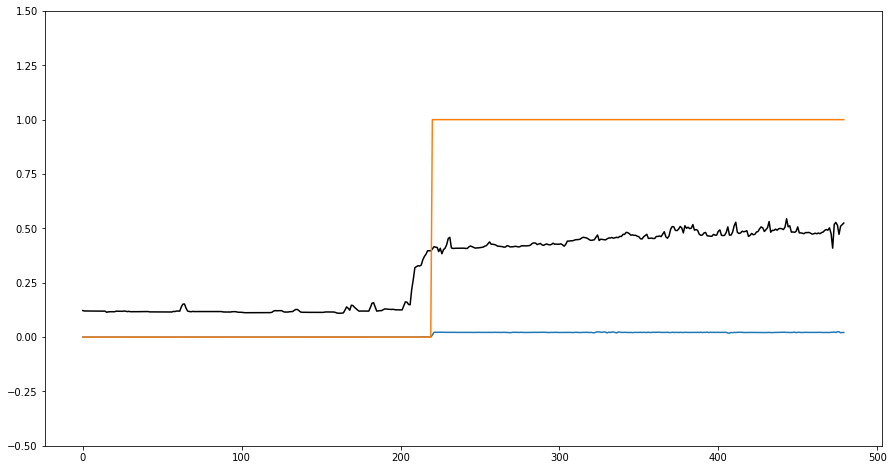

In [25]:
plt.figure(figsize=(15,8))
#x, y, s = dataiter.next()
a = 1
for i in range(100):
    x, y, s = dataiter.next()
    if y[0,:,a].sum() > 0:
        break
    if s[0,:,a].sum() > 0:
        break
plt.plot(np.arange(-BORDER, SEQ_LEN + BORDER), x[0,:].detach().numpy(), 'k-')
plt.plot(y[0,:,a].detach().numpy())
plt.plot(s[0,:,a].detach().numpy())
plt.ylim([-0.5,1.5])

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FocalLoss(nn.Module):
    def __init__(self, pos_weight, gamma):
        super(FocalLoss, self).__init__()
        self.pos_weight  = pos_weight
        self.gamma = gamma
        
    def forward(self, y_pred, y_true):
    # y_pred is the logits without Sigmoid
        assert y_pred.shape == y_true.shape
        pt = torch.exp(-F.binary_cross_entropy_with_logits(y_pred, y_true, reduction='none')).detach().cuda()
        sample_weight = (1 - pt) **  self.gamma
        return F.binary_cross_entropy_with_logits(y_pred, y_true, weight= sample_weight.cuda(), pos_weight=self.pos_weight.cuda()).cuda()

In [27]:
batch_size = BATCH_SIZE
n_epochs = Epochs

train_loader = dl_train_seen
valid_loader = dl_valid_seen
test_loader = dl_test_seen

#i = 0
for i in range(jb):
    print('TRAINING MODEL %d' %i)
    # Instantiate the model
    model = TTRNet(1,4,32).cuda()
    optimizer = optim.Adam(model.parameters(), lr=1.E-5)
    criterion = FocalLoss(pos_weight=torch.tensor([1.23,1.5,1,1]), gamma=2)
    fn = './seen/UKDALE_seen_%d.pth' %i
    model, train_loss, valid_loss, test_loss = train_model(model, batch_size, n_epochs, fn)

TRAINING MODEL 0
[  1/100] train_loss: 0.18462 valid_loss: 0.19294 test_loss: 0.18069 
Validation loss decreased (inf --> 0.192941).  Saving model ...
[  2/100] train_loss: 0.17950 valid_loss: 0.18674 test_loss: 0.17432 
Validation loss decreased (0.192941 --> 0.186742).  Saving model ...
[  3/100] train_loss: 0.17382 valid_loss: 0.17877 test_loss: 0.16605 
Validation loss decreased (0.186742 --> 0.178774).  Saving model ...
[  4/100] train_loss: 0.16628 valid_loss: 0.17004 test_loss: 0.15801 
Validation loss decreased (0.178774 --> 0.170043).  Saving model ...
[  5/100] train_loss: 0.15721 valid_loss: 0.16413 test_loss: 0.14916 
Validation loss decreased (0.170043 --> 0.164128).  Saving model ...
[  6/100] train_loss: 0.14933 valid_loss: 0.15228 test_loss: 0.13932 
Validation loss decreased (0.164128 --> 0.152283).  Saving model ...
[  7/100] train_loss: 0.13827 valid_loss: 0.14063 test_loss: 0.12729 
Validation loss decreased (0.152283 --> 0.140628).  Saving model ...
[  8/100] train

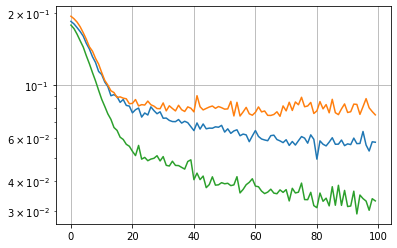

In [28]:
plt.plot(train_loss)
plt.plot(valid_loss)
plt.plot(test_loss)

plt.yscale('log')
plt.grid(True)

In [29]:
batch_size = BATCH_SIZE
n_epochs = Epochs

train_loader = dl_train_unseen
valid_loader = dl_valid_unseen
test_loader = dl_test_unseen

#i = 0
for i in range(jb):
    print('TRAINING MODEL %d' %i)
    # Instantiate the model
    model = TTRNet(1,4,32).cuda()
    optimizer = optim.Adam(model.parameters(), lr=1.E-5)
    criterion = FocalLoss(pos_weight=torch.tensor([1.23,1.5,1,1]), gamma=2)
    fn = './unseen/UKDALE_unseen_%d.pth' %i
    model, train_loss, valid_loss, test_loss = train_model(model, batch_size, n_epochs, fn)

TRAINING MODEL 0
[  1/100] train_loss: 0.18451 valid_loss: 0.19308 test_loss: 0.18622 
Validation loss decreased (inf --> 0.193082).  Saving model ...
[  2/100] train_loss: 0.18240 valid_loss: 0.19235 test_loss: 0.18493 
Validation loss decreased (0.193082 --> 0.192349).  Saving model ...
[  3/100] train_loss: 0.18158 valid_loss: 0.19101 test_loss: 0.18304 
Validation loss decreased (0.192349 --> 0.191006).  Saving model ...
[  4/100] train_loss: 0.17850 valid_loss: 0.18919 test_loss: 0.18064 
Validation loss decreased (0.191006 --> 0.189193).  Saving model ...
[  5/100] train_loss: 0.17667 valid_loss: 0.18729 test_loss: 0.17780 
Validation loss decreased (0.189193 --> 0.187287).  Saving model ...
[  6/100] train_loss: 0.17482 valid_loss: 0.18494 test_loss: 0.17506 
Validation loss decreased (0.187287 --> 0.184936).  Saving model ...
[  7/100] train_loss: 0.17310 valid_loss: 0.18238 test_loss: 0.17209 
Validation loss decreased (0.184936 --> 0.182376).  Saving model ...
[  8/100] train

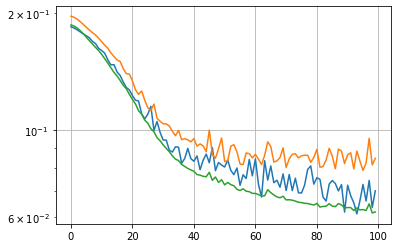

In [30]:
plt.plot(train_loss)
plt.plot(valid_loss)
plt.plot(test_loss)

plt.yscale('log')
plt.grid(True)

In [31]:
model = TTRNet(1,4,32).cuda()
model.eval()

TTRNet(
  (embed): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TemporalEmbedding(
      (hour_embed): FixedEmbedding(
        (emb): Embedding(24, 256)
      )
      (weekday_embed): FixedEmbedding(
        (emb): Embedding(7, 256)
      )
      (day_embed): FixedEmbedding(
        (emb): Embedding(32, 256)
      )
      (month_embed): FixedEmbedding(
        (emb): Embedding(13, 256)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer1): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=256, b

In [32]:
scores = {}
for a in range(4):
    scores[a] = {}
    scores[a]['F1'] = []
    scores[a]['Precision'] = []
    scores[a]['Recall'] = []
    scores[a]['Accuracy'] = []
    scores[a]['MCC'] = []
    scores[a]['MAE'] = []
    scores[a]['SAE'] = []

thr = 0.6
for i in range(jb):
    #filename = '/content/gdrive/My Drive/NILM/UKDALE_seen_%d.pth' %i
    filename = './seen/UKDALE_seen_%d.pth' %i
    print(filename)
    model.load_state_dict(torch.load(filename))
    for a in range(4):
        #x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[0], a)
        #pm = p_true.sum() / s_true.sum()
        #pm = (ds_appliance[0][APPLIANCE[a]] * 
        #      ds_status[0][APPLIANCE[a]]).sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        pm = ds_appliance[0][APPLIANCE[a]].sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_test[0], a)
        s_hat = get_status(s_hat, thr, MIN_OFF[a], MIN_ON[a])
        p_hat = pm * s_hat
        scores[a]['F1'].append(f1_score(s_true, s_hat))
        scores[a]['Precision'].append(precision_score(s_true, s_hat))
        scores[a]['Recall'].append(recall_score(s_true, s_hat))
        scores[a]['Accuracy'].append(accuracy_score(s_true, s_hat))
        scores[a]['MCC'].append(matthews_corrcoef(s_true, s_hat))
        scores[a]['MAE'].append(mean_absolute_error(p_true, p_hat)*MAX_POWER)
        scores[a]['SAE'].append((p_hat.sum() - p_true.sum()) / p_true.sum())
np.save('seen.npy', scores) 
for i,a in enumerate(APPLIANCE):
    print()
    print(a)
    print('F1 score  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['F1']), sorted(scores[i]['F1'])[1], sorted(scores[i]['F1'])[18]))
    print('Precision : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Precision']), sorted(scores[i]['Precision'])[1], sorted(scores[i]['Precision'])[18]))
    print('Recall    : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Recall']), sorted(scores[i]['Recall'])[1], sorted(scores[i]['Recall'])[18]))
    print('Accuracy  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Accuracy']), sorted(scores[i]['Accuracy'])[1], sorted(scores[i]['Accuracy'])[18]))
    print('MCC       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['MCC']), sorted(scores[i]['MCC'])[1], sorted(scores[i]['MCC'])[18]))
    print('MAE       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['MAE']), sorted(scores[i]['MAE'])[1], sorted(scores[i]['MAE'])[18]))
    print('SAE       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['SAE']), sorted(scores[i]['SAE'])[1], sorted(scores[i]['SAE'])[18]))
    
    


./seen/UKDALE_seen_0.pth
./seen/UKDALE_seen_1.pth
./seen/UKDALE_seen_2.pth
./seen/UKDALE_seen_3.pth
./seen/UKDALE_seen_4.pth
./seen/UKDALE_seen_5.pth
./seen/UKDALE_seen_6.pth
./seen/UKDALE_seen_7.pth
./seen/UKDALE_seen_8.pth
./seen/UKDALE_seen_9.pth
./seen/UKDALE_seen_10.pth
./seen/UKDALE_seen_11.pth
./seen/UKDALE_seen_12.pth
./seen/UKDALE_seen_13.pth
./seen/UKDALE_seen_14.pth
./seen/UKDALE_seen_15.pth
./seen/UKDALE_seen_16.pth
./seen/UKDALE_seen_17.pth
./seen/UKDALE_seen_18.pth
./seen/UKDALE_seen_19.pth

AHU0
F1 score  : 0.892 (0.817, 0.944)
Precision : 0.986 (0.964, 1.000)
Recall    : 0.819 (0.691, 0.912)
Accuracy  : 0.938 (0.901, 0.965)
MCC       : 0.859 (0.777, 0.920)
MAE       : 185.192 (121.699, 270.676)
SAE       : -0.148 (-0.292, -0.037)

AHU1
F1 score  : 0.951 (0.865, 0.996)
Precision : 0.978 (0.884, 1.000)
Recall    : 0.928 (0.836, 0.996)
Accuracy  : 0.979 (0.948, 0.998)
MCC       : 0.940 (0.845, 0.995)
MAE       : 142.766 (108.088, 220.303)
SAE       : -0.059 (-0.174, 0.071)

In [33]:
scores = {}
for a in range(4):
    scores[a] = {}
    scores[a]['F1'] = []
    scores[a]['Precision'] = []
    scores[a]['Recall'] = []
    scores[a]['Accuracy'] = []
    scores[a]['MCC'] = []
    scores[a]['MAE'] = []
    scores[a]['SAE'] = []

thr = 0.6

for i in range(jb):
    #filename = '/content/gdrive/My Drive/NILM/UKDALE_unseen_%d.pth' %i
    filename = './unseen/UKDALE_unseen_%d.pth' %i
    print(filename)
    model.load_state_dict(torch.load(filename))
    for a in range(4):
        #x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[1], a)
        #pm = p_true.sum() / s_true.sum()
        pm = ds_appliance[1][APPLIANCE[a]].sum() / ds_status[1][APPLIANCE[a]].sum() / MAX_POWER
        x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[1], a)
        s_hat = get_status(s_hat, thr, MIN_OFF[a], MIN_ON[a])
        p_hat = pm * s_hat
        scores[a]['F1'].append(f1_score(s_true, s_hat))
        scores[a]['Precision'].append(precision_score(s_true, s_hat))
        scores[a]['Recall'].append(recall_score(s_true, s_hat))
        scores[a]['Accuracy'].append(accuracy_score(s_true, s_hat))
        scores[a]['MCC'].append(matthews_corrcoef(s_true, s_hat))
        scores[a]['MAE'].append(mean_absolute_error(p_true, p_hat)*MAX_POWER)
        scores[a]['SAE'].append((p_hat.sum() - p_true.sum()) / p_true.sum())
np.save('unseen.npy', scores) 
for i,a in enumerate(APPLIANCE):
    print()
    print(a)
    print('F1 score  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['F1']), sorted(scores[i]['F1'])[1], sorted(scores[i]['F1'])[18]))
    print('Precision : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Precision']), sorted(scores[i]['Precision'])[1], sorted(scores[i]['Precision'])[18]))
    print('Recall    : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Recall']), sorted(scores[i]['Recall'])[1], sorted(scores[i]['Recall'])[18]))
    print('Accuracy  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Accuracy']), sorted(scores[i]['Accuracy'])[1], sorted(scores[i]['Accuracy'])[18]))
    print('MCC       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['MCC']), sorted(scores[i]['MCC'])[1], sorted(scores[i]['MCC'])[18]))
    print('MAE       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['MAE']), sorted(scores[i]['MAE'])[1], sorted(scores[i]['MAE'])[18]))
    print('SAE       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['SAE']), sorted(scores[i]['SAE'])[1], sorted(scores[i]['SAE'])[18]))
    


./unseen/UKDALE_unseen_0.pth
./unseen/UKDALE_unseen_1.pth
./unseen/UKDALE_unseen_2.pth
./unseen/UKDALE_unseen_3.pth
./unseen/UKDALE_unseen_4.pth
./unseen/UKDALE_unseen_5.pth
./unseen/UKDALE_unseen_6.pth
./unseen/UKDALE_unseen_7.pth
./unseen/UKDALE_unseen_8.pth
./unseen/UKDALE_unseen_9.pth
./unseen/UKDALE_unseen_10.pth
./unseen/UKDALE_unseen_11.pth
./unseen/UKDALE_unseen_12.pth
./unseen/UKDALE_unseen_13.pth
./unseen/UKDALE_unseen_14.pth
./unseen/UKDALE_unseen_15.pth
./unseen/UKDALE_unseen_16.pth
./unseen/UKDALE_unseen_17.pth
./unseen/UKDALE_unseen_18.pth
./unseen/UKDALE_unseen_19.pth

AHU0
F1 score  : 0.864 (0.854, 0.874)
Precision : 0.910 (0.877, 0.926)
Recall    : 0.823 (0.791, 0.862)
Accuracy  : 0.883 (0.877, 0.889)
MCC       : 0.765 (0.754, 0.776)
MAE       : 359.177 (345.369, 371.955)
SAE       : -0.095 (-0.148, -0.015)

AHU1
F1 score  : 0.827 (0.812, 0.843)
Precision : 0.871 (0.829, 0.916)
Recall    : 0.788 (0.743, 0.829)
Accuracy  : 0.867 (0.857, 0.880)
MCC       : 0.722 (0.701, 